In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [4]:
!kaggle datasets download -d paultimothymooney/blood-cells


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/blood-cells
License(s): other
  0% 0.00/108M [00:00<?, ?B/s]
100% 108M/108M [00:00<00:00, 1.25GB/s]


In [5]:
!unzip blood-cells.zip -d blood-cells

Streaming output truncated to the last 5000 lines.
  inflating: blood-cells/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8050.jpeg  
  inflating: blood-cells/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8167.jpeg  
  inflating: blood-cells/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8283.jpeg  
  inflating: blood-cells/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8324.jpeg  
  inflating: blood-cells/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8379.jpeg  
  inflating: blood-cells/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8577.jpeg  
  inflating: blood-cells/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8587.jpeg  
  inflating: blood-cells/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8655.jpeg  
  inflating: blood-cells/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8701.jpeg  
  inflating: blood-cells/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8

In [6]:
import os
import pandas as pd

# Set the base paths
Train_dir = '/content/blood-cells/dataset2-master/dataset2-master/images/TRAIN'
Test_dir = '/content/blood-cells/dataset2-master/dataset2-master/images/TEST'
Test_sample_dir = '/content/blood-cells/dataset2-master/dataset2-master/images/TEST_SAMPLE'

# List of (directory, list to hold data)
Paths = [(Train_dir, []), (Test_dir, [])] # (Test_sample_dir, [])]

# Loop through each directory
for dir_path, data_list in Paths:
    for label in os.listdir(dir_path):
        label_path = os.path.join(dir_path, label)
        if os.path.isdir(label_path):
            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)
                data_list.append([img_path, label])

# Create DataFrames
Train_df = pd.DataFrame(Paths[0][1], columns=['filepath', 'label'])
Test_df = pd.DataFrame(Paths[1][1], columns=['filepath', 'label'])
# Test_sample_df = pd.DataFrame(Paths[2][1], columns=['filepath', 'label'])

# Optionally: View samples
print("Train:", Train_df.shape)
print("Test:", Test_df.shape)
# print("Test Sample:", Test_sample_df.shape)
Train_df.head()


Train: (9957, 2)
Test: (2487, 2)


,filepath,label
0,/content/blood-cells/dataset2-master/dataset2-...,MONOCYTE
1,/content/blood-cells/dataset2-master/dataset2-...,MONOCYTE
2,/content/blood-cells/dataset2-master/dataset2-...,MONOCYTE
3,/content/blood-cells/dataset2-master/dataset2-...,MONOCYTE
4,/content/blood-cells/dataset2-master/dataset2-...,MONOCYTE


In [7]:
Train_df.head()

,filepath,label
0,/content/blood-cells/dataset2-master/dataset2-...,MONOCYTE
1,/content/blood-cells/dataset2-master/dataset2-...,MONOCYTE
2,/content/blood-cells/dataset2-master/dataset2-...,MONOCYTE
3,/content/blood-cells/dataset2-master/dataset2-...,MONOCYTE
4,/content/blood-cells/dataset2-master/dataset2-...,MONOCYTE


In [8]:
Train_df['label'].unique()

array(['MONOCYTE', 'NEUTROPHIL', 'LYMPHOCYTE', 'EOSINOPHIL'], dtype=object)

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def show_blood_cell_images(image_gen):
    class_indices = image_gen.class_indices
    classes = list(class_indices.keys())
    images, labels = next(image_gen)

    plt.figure(figsize=(20, 20))
    length = len(labels)
    r = min(length, 25)

    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image = (images[i] + 1) / 2  # Normalize if needed
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color="green", fontsize=14)
        plt.axis('off')

    plt.show()


Found 9957 images belonging to 4 classes.


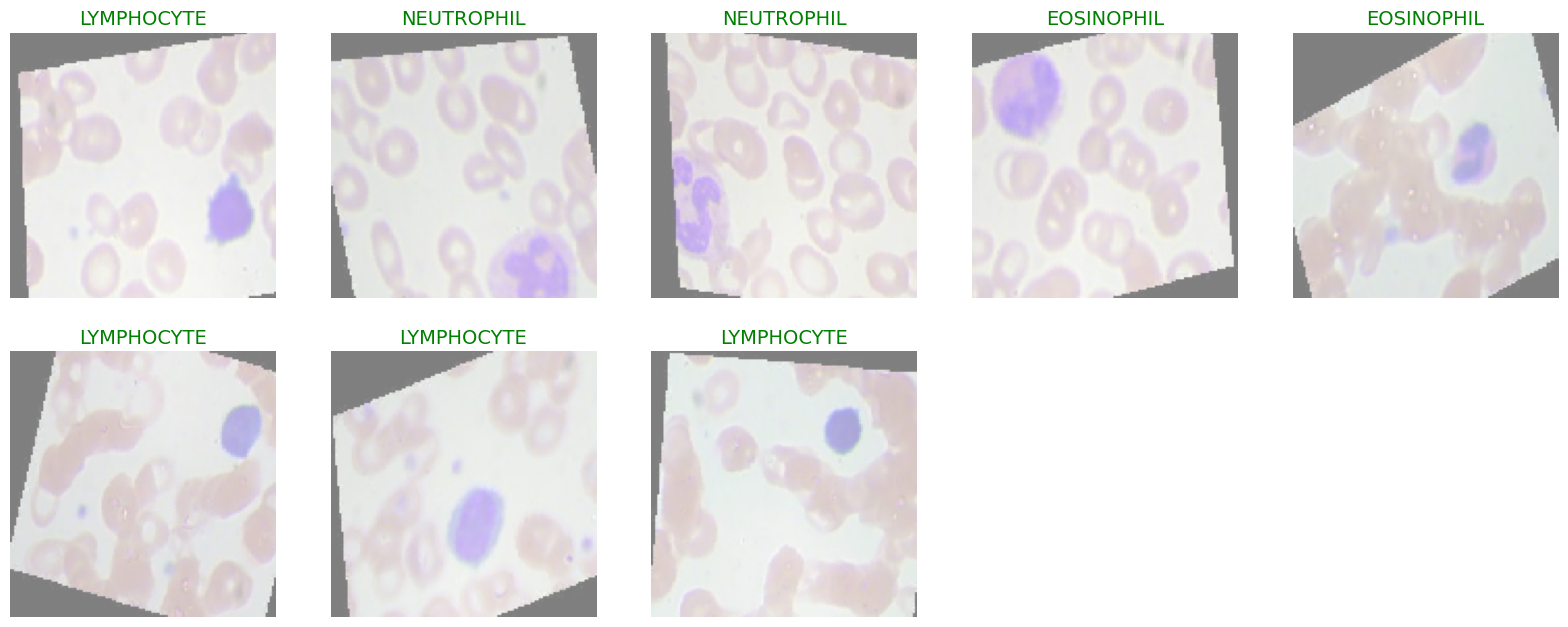

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    '/content/blood-cells/dataset2-master/dataset2-master/images/TRAIN',
    target_size=(128, 128),
    batch_size=8,
    class_mode='categorical',
    shuffle=True
)

show_blood_cell_images(train_generator)


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_dataframe(
    dataframe=Train_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_dataframe(
    dataframe=Test_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# history = model.fit(train_gen, validation_data=val_gen, batch_size = 16, epochs=5)


Found 7966 validated image filenames belonging to 4 classes.
Found 497 validated image filenames belonging to 4 classes.


In [12]:
test_gen = datagen.flow_from_dataframe(
    dataframe=Test_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

Found 497 validated image filenames belonging to 4 classes.


In [13]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dropout, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

# Load MobileNetV2 without the top classification layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

#Building Transfer learning model
model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 classes of blood cells
])

#Compiling model
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


#setup callbacks
checkpoint = ModelCheckpoint('blood_cell.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

#Training model
history = model.fit(
    train_gen,  # training generator
    epochs=3,
    validation_data=val_gen,  # validation generator
    callbacks=[checkpoint, early_stop],
    verbose=1
)

#Model summary
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


498/498 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.5697 - loss: 4.5942
Epoch 1: val_accuracy improved from -inf to 0.24748, saving model to blood_cell.h5


498/498 ━━━━━━━━━━━━━━━━━━━━ 298s 588ms/step - accuracy: 0.5698 - loss: 4.5921 - val_accuracy: 0.2475 - val_loss: 12.7562
Epoch 2/3
 31/498 ━━━━━━━━━━━━━━━━━━━━ 4:08 531ms/step - accuracy: 0.8222 - loss: 1.4777

KeyboardInterrupt: 

In [14]:
# Evaluate the saved model
from tensorflow.keras.models import load_model

# Load the best model
model = load_model('blood_cell.h5')

# Evaluate on test data
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 499ms/step - accuracy: 0.2628 - loss: 12.8847
Test Accuracy: 0.2475
Test Loss: 12.7562


NameError: name 'history' is not defined

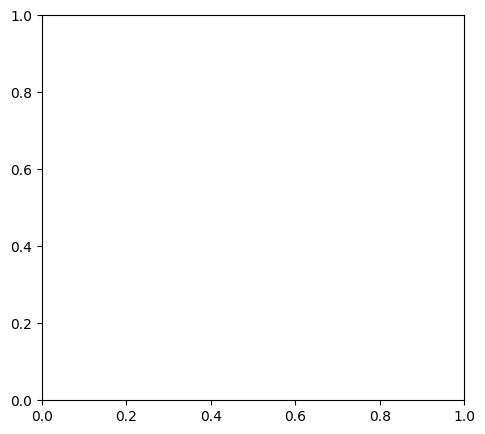

In [15]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [16]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Load MobileNetV2 without the top classification layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model initially

# Build model with regularization and global pooling
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # More efficient than Flatten for CNNs
    Dropout(0.5),
    Dense(4, activation='softmax', kernel_regularizer=l2(0.01))  # Add L2 regularization
])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
checkpoint = ModelCheckpoint('blood_cell.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

# Train model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,  # You can still stop early with EarlyStopping
    callbacks=[checkpoint, early_stop, reduce_lr],
    verbose=1
)

# Print model summary
model.summary()


Epoch 1/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.3020 - loss: 1.9244
Epoch 1: val_accuracy improved from -inf to 0.00604, saving model to blood_cell.h5


498/498 ━━━━━━━━━━━━━━━━━━━━ 290s 571ms/step - accuracy: 0.3021 - loss: 1.9240 - val_accuracy: 0.0060 - val_loss: 2.7568 - learning_rate: 1.0000e-04
Epoch 2/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - accuracy: 0.4135 - loss: 1.4836
Epoch 2: val_accuracy did not improve from 0.00604
498/498 ━━━━━━━━━━━━━━━━━━━━ 284s 571ms/step - accuracy: 0.4136 - loss: 1.4835 - val_accuracy: 0.0020 - val_loss: 2.8008 - learning_rate: 1.0000e-04
Epoch 3/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.4796 - loss: 1.3035
Epoch 3: val_accuracy did not improve from 0.00604
498/498 ━━━━━━━━━━━━━━━━━━━━ 281s 564ms/step - accuracy: 0.4796 - loss: 1.3035 - val_accuracy: 0.0040 - val_loss: 2.7301 - learning_rate: 1.0000e-04
Epoch 4/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.5093 - loss: 1.2304
Epoch 4: val_accuracy improved from 0.00604 to 0.01811, saving model to blood_cell.h5


498/498 ━━━━━━━━━━━━━━━━━━━━ 317s 636ms/step - accuracy: 0.5094 - loss: 1.2303 - val_accuracy: 0.0181 - val_loss: 2.6578 - learning_rate: 1.0000e-04
Epoch 5/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.5358 - loss: 1.1347
Epoch 5: val_accuracy did not improve from 0.01811
498/498 ━━━━━━━━━━━━━━━━━━━━ 280s 562ms/step - accuracy: 0.5358 - loss: 1.1346 - val_accuracy: 0.0141 - val_loss: 2.6169 - learning_rate: 1.0000e-04
Epoch 6/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.5655 - loss: 1.0696
Epoch 6: val_accuracy improved from 0.01811 to 0.05634, saving model to blood_cell.h5


498/498 ━━━━━━━━━━━━━━━━━━━━ 282s 566ms/step - accuracy: 0.5656 - loss: 1.0696 - val_accuracy: 0.0563 - val_loss: 2.4183 - learning_rate: 1.0000e-04
Epoch 7/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.5838 - loss: 1.0436
Epoch 7: val_accuracy did not improve from 0.05634
498/498 ━━━━━━━━━━━━━━━━━━━━ 280s 562ms/step - accuracy: 0.5838 - loss: 1.0435 - val_accuracy: 0.0322 - val_loss: 2.4859 - learning_rate: 1.0000e-04
Epoch 8/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.6140 - loss: 0.9846
Epoch 8: val_accuracy improved from 0.05634 to 0.05835, saving model to blood_cell.h5



Epoch 8: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
498/498 ━━━━━━━━━━━━━━━━━━━━ 281s 564ms/step - accuracy: 0.6140 - loss: 0.9846 - val_accuracy: 0.0584 - val_loss: 2.4507 - learning_rate: 1.0000e-04
Epoch 9/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.6269 - loss: 0.9448
Epoch 9: val_accuracy improved from 0.05835 to 0.07042, saving model to blood_cell.h5


498/498 ━━━━━━━━━━━━━━━━━━━━ 281s 565ms/step - accuracy: 0.6269 - loss: 0.9448 - val_accuracy: 0.0704 - val_loss: 2.3642 - learning_rate: 5.0000e-05
Epoch 10/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - accuracy: 0.6308 - loss: 0.9393
Epoch 10: val_accuracy did not improve from 0.07042
498/498 ━━━━━━━━━━━━━━━━━━━━ 287s 576ms/step - accuracy: 0.6308 - loss: 0.9393 - val_accuracy: 0.0523 - val_loss: 2.4540 - learning_rate: 5.0000e-05
Epoch 11/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - accuracy: 0.6355 - loss: 0.9359
Epoch 11: val_accuracy did not improve from 0.07042

Epoch 11: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
498/498 ━━━━━━━━━━━━━━━━━━━━ 282s 567ms/step - accuracy: 0.6355 - loss: 0.9359 - val_accuracy: 0.0624 - val_loss: 2.4511 - learning_rate: 5.0000e-05
Epoch 12/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.6403 - loss: 0.9185
Epoch 12: val_accuracy improved from 0.07042 to 0.08048, saving model to blood_cell.h5


498/498 ━━━━━━━━━━━━━━━━━━━━ 282s 567ms/step - accuracy: 0.6403 - loss: 0.9185 - val_accuracy: 0.0805 - val_loss: 2.3258 - learning_rate: 2.5000e-05
Epoch 13/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.6430 - loss: 0.9041
Epoch 13: val_accuracy did not improve from 0.08048
498/498 ━━━━━━━━━━━━━━━━━━━━ 283s 568ms/step - accuracy: 0.6430 - loss: 0.9041 - val_accuracy: 0.0785 - val_loss: 2.3472 - learning_rate: 2.5000e-05
Epoch 14/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.6428 - loss: 0.9070
Epoch 14: val_accuracy did not improve from 0.08048

Epoch 14: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
498/498 ━━━━━━━━━━━━━━━━━━━━ 283s 569ms/step - accuracy: 0.6428 - loss: 0.9070 - val_accuracy: 0.0765 - val_loss: 2.3911 - learning_rate: 2.5000e-05
Epoch 15/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.6503 - loss: 0.8945
Epoch 15: val_accuracy did not improve from 0.08048
498/498 ━━━━━━━━━━━━━━━━━━━━ 278s 559ms/step - accur

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,273,358 (8.67 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 10,250 (40.04 KB)

In [17]:
# Evaluate the saved model
from tensorflow.keras.models import load_model

# Load the best model
model = load_model('blood_cell.h5')

# Evaluate on test data
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 503ms/step - accuracy: 0.0762 - loss: 2.3461
Test Accuracy: 0.0805
Test Loss: 2.3258


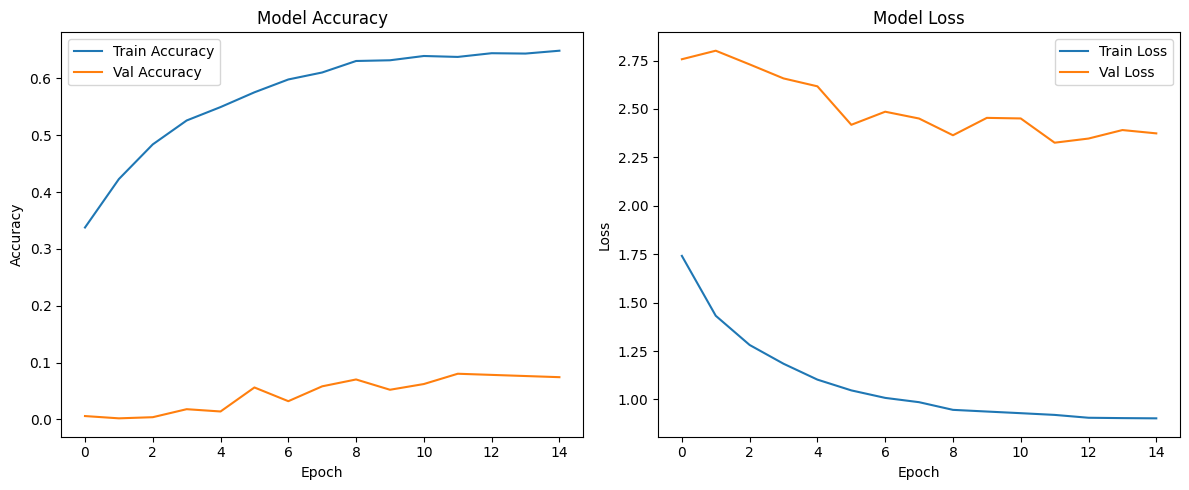

In [18]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [21]:
from google.colab import files
files.download('blood_cell.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>